In [1]:
import torch
import wave
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
text = "Le soleil adore vos pastels, un chœur qui bat fort de ritournelles. Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."

In [3]:
def get_audio_duration(filepath_no_extention):
    try :
        with wave.open(filepath_no_extention + '.wav', 'r') as f:
            frames = f.getnframes()
            rate = f.getframerate()
    except:
        with wave.open(filepath_no_extention + '.mp3', 'r') as f:
            frames = f.getnframes()
            rate = f.getframerate()
    
    return frames / float(rate)

def save_to_csv(output_name, time_init, time_infer, model_name):
    df = pd.read_csv('time_analysis.csv', header=0)
    df = df.append({
        'file': output_name, 
        'time_init': time_init, 
        'time_infer': time_infer, 
        'model': model_name,
        'audio_duration': get_audio_duration(output_name),
        'text': text
        }, ignore_index=True)
    df.to_csv('time_analysis.csv', index=False)

## PyTTSX4

In [4]:
import pyttsx4

In [5]:
t1 = time.time()
engine = pyttsx4.init()
t2 = time.time()
time_init = t2 - t1

t1 = time.time()
engine.save_to_file(text, 'pyttsx4.mp3')
engine.runAndWait()
t2 = time.time()
time_infer = t2 - t1

save_to_csv('pyttsx4', time_init, time_infer, 'pyttsx4')

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


## MELO

In [6]:
import MeCab
from melo.api import TTS

c:\Users\echriston\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Speed is adjustable
speed = 1.0

# CPU is sufficient for real-time inference.
# You can set it manually to 'cpu' or 'cuda' or 'cuda:0' or 'mps'
device = 'auto' # Will automatically use GPU if available

t1 = time.time()
model = TTS(language='FR', device=device)
speaker_ids = model.hps.data.spk2id
t2 = time.time()
time_init = t2 - t1

# American accent
output_path = 'melo-fr.wav'
t1 = time.time()
model.tts_to_file(text, speaker_ids['FR'], output_path, speed=speed)
t2 = time.time()
time_infer = t2 - t1

save_to_csv('melo-fr', time_init, time_infer, 'melo-fr')

c:\Users\echriston\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


 > Text split to sentences.
Le soleil adore vos pastels, un chœur qui bat fort de ritournelles. Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre.
 > ===========================


100%|██████████| 1/1 [00:10<00:00, 10.85s/it]
C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


## TTS lib

In [8]:
from TTS.api import TTS

In [9]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

# List available 🐸TTS models
print("\n".join(TTS().list_models().list_models()))

tts_models/multilingual/multi-dataset/xtts_v2
tts_models/multilingual/multi-dataset/xtts_v1.1
tts_models/multilingual/multi-dataset/your_tts
tts_models/multilingual/multi-dataset/bark
tts_models/bg/cv/vits
tts_models/cs/cv/vits
tts_models/da/cv/vits
tts_models/et/cv/vits
tts_models/ga/cv/vits
tts_models/en/ek1/tacotron2
tts_models/en/ljspeech/tacotron2-DDC
tts_models/en/ljspeech/tacotron2-DDC_ph
tts_models/en/ljspeech/glow-tts
tts_models/en/ljspeech/speedy-speech
tts_models/en/ljspeech/tacotron2-DCA
tts_models/en/ljspeech/vits
tts_models/en/ljspeech/vits--neon
tts_models/en/ljspeech/fast_pitch
tts_models/en/ljspeech/overflow
tts_models/en/ljspeech/neural_hmm
tts_models/en/vctk/vits
tts_models/en/vctk/fast_pitch
tts_models/en/sam/tacotron-DDC
tts_models/en/blizzard2013/capacitron-t2-c50
tts_models/en/blizzard2013/capacitron-t2-c150_v2
tts_models/en/multi-dataset/tortoise-v2
tts_models/en/jenny/jenny
tts_models/es/mai/tacotron2-DDC
tts_models/es/css10/vits
tts_models/fr/mai/tacotron2-DDC

In [10]:
def test_model(model_name, text, speaker_path, save_csv=True, display=True):
    start = time.time()
    # Load model
    tts = TTS(model_name).to(device)
    time_init = time.time() - start

    output_name = get_output_name(model_name, speaker_path)

    # Synthesize
    if "multilingual" in model_name:
        try:
            start = time.time()
            tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav', language="fr-fr")
            time_infer = time.time() - start
        except:
            try:
                start = time.time()
                tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav', language="fr")
                time_infer = time.time() - start
            except:
                try:
                    start = time.time()
                    tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav', language="fra")
                    time_infer = time.time() - start
                except Exception as e:
                    raise e
    else:
        start = time.time()
        tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav')
        time_infer = time.time() - start
    
    if display:
        print(f"\n==============================================\nModel: {model_name}")
        print(f"Time to initialize the model: {time_init:.2f} s")
        print(f"Time to synthesize the text: {time_infer:.2f} s")

    if save_csv:
        save_to_csv(output_name, time_init, time_infer, "-".join(output_name.split('-')[:-1]))

def get_output_name(model_name, speaker_path):
    if len(model_name.split('/')) != 4:
        raise ValueError('model_name must be in the form of "tts_model/language/model_tag/model_name"')
    _, language, model_tag, model_main = model_name.split('/')
    return model_main + '-' + model_tag + '-' + language + '-' + speaker_path.split('/')[-1].split('.')[0]

In [11]:
tts_to_test = [
    # "tts_models/multilingual/multi-dataset/xtts_v2",
    "tts_models/multilingual/multi-dataset/your_tts",
    "tts_models/fr/mai/tacotron2-DDC",
    "tts_models/fr/css10/vits",
    "tts_models/fra/fairseq/vits",
    "tts_models/acf/fairseq/vits",
]

voice_folder = "../../../data/stored/assistant/voices/"

speakers_to_test = [voice_folder + speaker for speaker in os.listdir(voice_folder) if speaker.endswith('.wav') or speaker.endswith('.flac') or speaker.endswith('.mp3')]
print(speakers_to_test)

for model in tts_to_test:
    if "multilingual" in model:
        speakers = speakers_to_test
    else:
        speakers = [speakers_to_test[0]]
    for speaker in speakers:
        print(f"Testing {model} with speaker {speaker}")
        test_model(model, text, speaker, save_csv=True, display=True)
        print("==============================================")


['../../../data/stored/assistant/voices/eliot_christon.mp3', '../../../data/stored/assistant/voices/eugenie_declaron.mp3', '../../../data/stored/assistant/voices/example_reference.mp3', '../../../data/stored/assistant/voices/jean_pierre_pernaut.mp3', '../../../data/stored/assistant/voices/perrine_laffont.mp3', '../../../data/stored/assistant/voices/pierre_faury.mp3', '../../../data/stored/assistant/voices/ptisham.mp3', '../../../data/stored/assistant/voices/roberto_caurand.mp3', '../../../data/stored/assistant/voices/teddy_riner.mp3', '../../../data/stored/assistant/voices/thomas_oxisoglou.mp3']
Testing tts_models/multilingual/multi-dataset/your_tts with speaker ../../../data/stored/assistant/voices/eliot_christon.mp3
 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > Text splitted to sentences.
['Le soleil adore vos pastels, un chœur qui bat fort de ritournelles.', "Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."]
 > Processing time: 1.462587594985962
 > Real

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > Text splitted to sentences.
['Le soleil adore vos pastels, un chœur qui bat fort de ritournelles.', "Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."]
 > Processing time: 1.3807015419006348
 > Rea

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > Text splitted to sentences.
['Le soleil adore vos pastels, un chœur qui bat fort de ritournelles.', "Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."]
 > Processing time: 2.1802048683166504
 > Rea

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: fullband_melgan
 > Setting up Audio Processor...
 | > sample_rate:24000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > pitch_fmin:0.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:C:\Users\echriston\AppData\Local\tts\vocoder_models--universal--libri-tts--fullband-melgan\scale_stats.npy
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Generator Model: fullband_melgan_generator
 > Discriminator Model: melgan

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Text splitted to sentences.
['Le soleil adore vos pastels, un chœur qui bat fort de ritournelles.', "Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."]
 > Processing time: 1.0813612937927246
 > Real-time factor: 0.12584453918325442

Model: tts_models/fr/css10/vits
Time to initialize the model: 0.55 s
Time to synthesize the text: 1.11 s
Testing tts_models/fra/fairseq/vits with speaker ../../../data/stored/assistant/voices/eliot_christon.mp3
 > tts_models/fra/fairseq/vits is already downloaded.
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > ma

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Text splitted to sentences.
['Le soleil adore vos pastels, un chœur qui bat fort de ritournelles.', "Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."]
le soleil adore vos pastels, un chœur qui bat fort de ritournelles.
 [!] Character ',' not found in the vocabulary. Discarding it.
le soleil adore vos pastels, un chœur qui bat fort de ritournelles.
 [!] Character '.' not found in the vocabulary. Discarding it.
 > Processing time: 3.0010085105895996
 > Real-time factor: 0.2794755550930899

Model: tts_models/fra/fairseq/vits
Time to initialize the model: 1.03 s
Time to synthesize the text: 3.02 s
Testing tts_models/acf/fairseq/vits with speaker ../../../data/stored/assistant/voices/eliot_christon.mp3
 > tts_models/acf/fairseq/vits is already downloaded.
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:Non

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Text splitted to sentences.
['Le soleil adore vos pastels, un chœur qui bat fort de ritournelles.', "Attends-moi je sors de l'île aux cerfs, L'orage est de l'or pour se perdre."]
le soleil adore vos pastels, un chœur qui bat fort de ritournelles.
 [!] Character ',' not found in the vocabulary. Discarding it.
le soleil adore vos pastels, un chœur qui bat fort de ritournelles.
 [!] Character 'œ' not found in the vocabulary. Discarding it.
le soleil adore vos pastels, un chœur qui bat fort de ritournelles.
 [!] Character 'q' not found in the vocabulary. Discarding it.
le soleil adore vos pastels, un chœur qui bat fort de ritournelles.
 [!] Character '.' not found in the vocabulary. Discarding it.
attends-moi je sors de l'île aux cerfs, l'orage est de l'or pour se perdre.
 [!] Character 'î' not found in the vocabulary. Discarding it.
attends-moi je sors de l'île aux cerfs, l'orage est de l'or pour se perdre.
 [!] Character 'x' not found in the vocabulary. Discarding it.
 > Processing ti

C:\Users\echriston\AppData\Local\Temp\ipykernel_18372\4150352947.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


## Latency Analysis

In [4]:
# load time_analysis.csv
df = pd.read_csv('time_analysis.csv', header=0)

df = df.sort_values(by=['model', 'audio_duration'])

# display the dataframe
print(df.head())

        file  time_init  time_infer    model  audio_duration  \
27   melo-fr   1.596250    6.594031  melo-fr        1.942426   
79   melo-fr   1.383917    5.929463  melo-fr        3.939342   
147  melo-fr   0.834923    5.980578  melo-fr        6.447098   
131  melo-fr   1.481493    8.229214  melo-fr        6.957937   
105  melo-fr   1.369948    8.058554  melo-fr        7.097256   

                                                  text  
27                      Hey, moi c'est NAO, ça roule ?  
79   Et pourquoi pas ? C'est une bonne idée ! Je po...  
147  Regardez, c'est un oiseau! J'aimerais bien êtr...  
131  De fréquents séjours à Naples et en Espagne, à...  
105  De fréquents séjours à Naples et en Espagne, à...  


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1)
poly_reg = LinearRegression()

def get_poly_x_y(input_x, input_y, origin=True):
    if origin:
        input_x = np.insert(input_x, 0, 0)
        input_y = np.insert(input_y, 0, 0)
        input_x = np.insert(input_x, 0, 0)
        input_y = np.insert(input_y, 0, 0)
        input_x = np.insert(input_x, 0, 0)
        input_y = np.insert(input_y, 0, 0)
    X = input_x.reshape(-1, 1)
    y = input_y
    X_poly = poly.fit_transform(X)
    poly_reg.fit(X_poly, y)
    # new x values
    x_new = np.linspace(X.min()-1, X.max()+1, 100)
    X_new = x_new.reshape(-1, 1)
    X_new_poly = poly.fit_transform(X_new)
    y_new = poly_reg.predict(X_new_poly)

    slope = poly_reg.coef_[1]

    return x_new, y_new, slope



In [6]:
# exclude model xtts from the plot
df_plot = df.copy()
df_plot = df[df['model'] != 'xtts_v2-multi-dataset-multilingual']

cmap = plt.get_cmap('tab10')

models = df_plot['model'].unique()
colors = {model: cmap(i) for i, model in enumerate(models)}

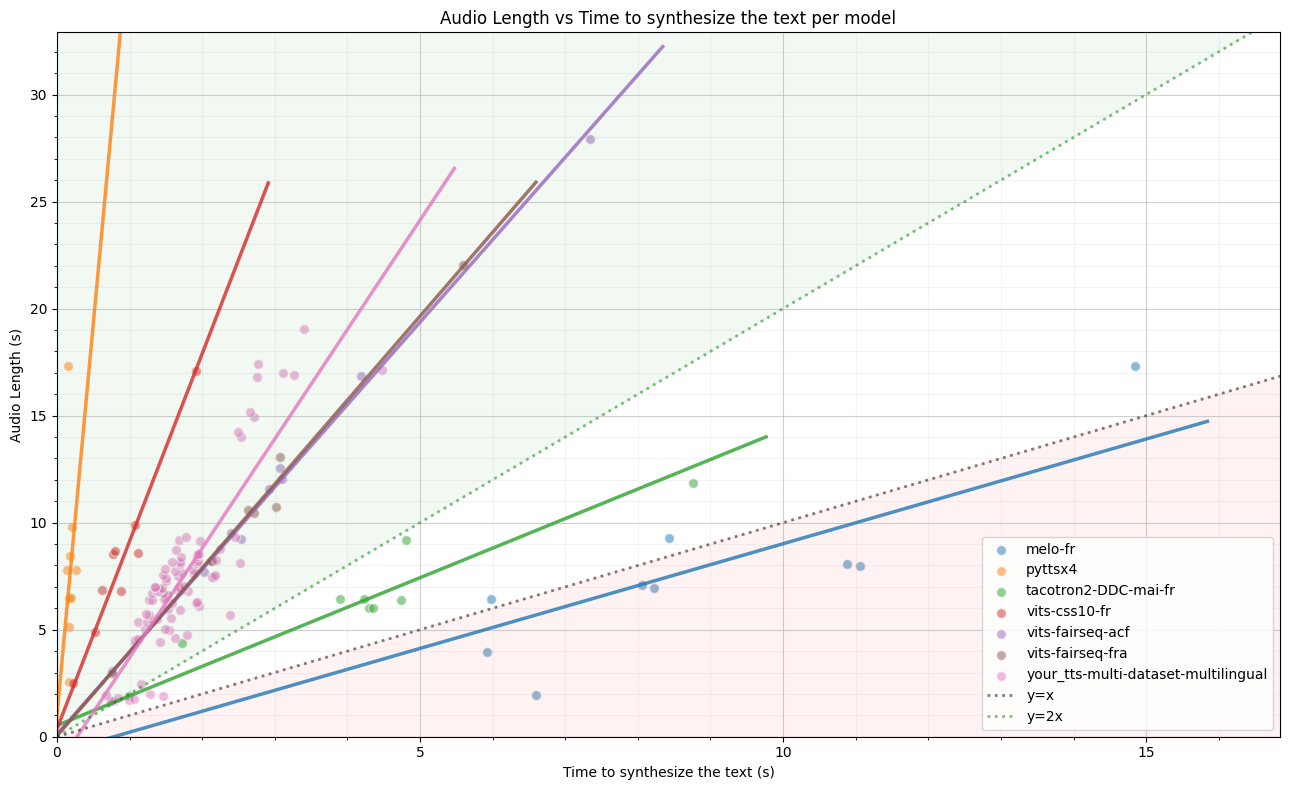

In [10]:
# plot the audio length vs the time to synthesize the text per model

fig, ax = plt.subplots(figsize=(13, 8))
for txt in models:
    color = colors[txt]
    df_filtered = df_plot[df_plot['model'] == txt]
    ax.scatter(df_filtered['time_infer'], df_filtered['audio_duration'], color=color, marker='o', s=50, alpha=0.5, linewidths=1, edgecolors='w', label=txt)
    # plot polynomial regression
    x_new, y_new, _ = get_poly_x_y(df_filtered['time_infer'].values, df_filtered['audio_duration'].values)
    ax.plot(x_new, y_new, alpha=0.8, linewidth=2.5, color=color)

# plot the diagonal
x = np.linspace(0, 151, 100)
y = x
ax.plot(x, y, 'k:', label='y=x', alpha=0.5, linewidth=2)
ax.plot(x, 2*y, 'g:', label='y=2x', alpha=0.5, linewidth=2)
ax.fill_between(x, 2*y, max(y)*np.ones_like(x), color='green', alpha=0.05)
ax.fill_between(x, 0, y, color='red', alpha=0.05)

# legend outside the plot
ax.legend()
ax.set_ylabel('Audio Length (s)')
ax.set_xlabel('Time to synthesize the text (s)')
ax.set_title('Audio Length vs Time to synthesize the text per model')
major_ticks = np.arange(0, 151, 5)
minor_ticks = np.arange(0, 151, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='major', alpha=0.6)
ax.grid(which='minor', alpha=0.15)
ax.set_xlim(max(0, min(df_plot['time_infer']) - 2), max(df_plot['time_infer']) + 2)
ax.set_ylim(max(0, min(df_plot['audio_duration']) - 5), max(df_plot['audio_duration']) + 5)
plt.tight_layout()
plt.show()


                                 model      slope
0                              pyttsx4  36.564964
0                        vits-css10-fr   8.765697
0  your_tts-multi-dataset-multilingual   5.109779
0                     vits-fairseq-fra   3.920774
0                     vits-fairseq-acf   3.851837
0                 tacotron2-DDC-mai-fr   1.380869
0                              melo-fr   0.978343
0   xtts_v2-multi-dataset-multilingual   0.336539


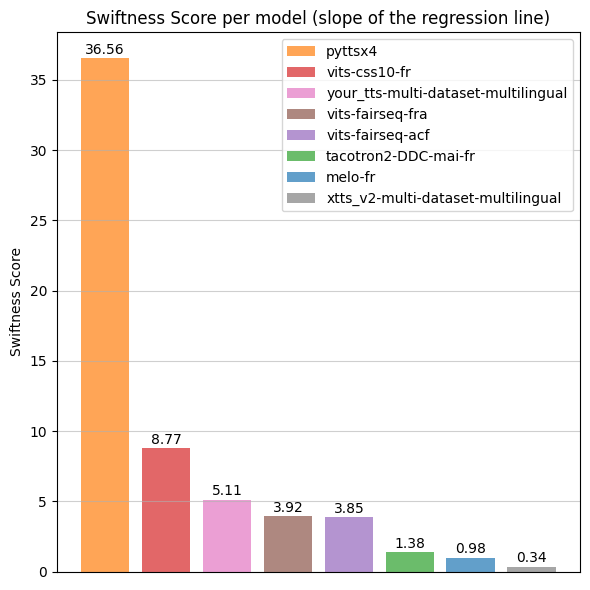

In [8]:
# make the slope a score per model
df_slope = pd.DataFrame(columns=['model', 'slope'])
for model in df['model'].unique():
    df_filtered = df[df['model'] == model]
    _, _, slope = get_poly_x_y(df_filtered['time_infer'].values, df_filtered['audio_duration'].values)
    df_slope = pd.concat([df_slope, pd.DataFrame({'model': [model], 'slope': [slope]})])

df_slope = df_slope.sort_values(by='slope', ascending=False)
print(df_slope)

# plot the score per model (bar plot)
fig, ax = plt.subplots(figsize=(6, 6))
for i, row in df_slope.iterrows():
    if row['model'] in colors:
        color = colors[row['model']]
    else:
        color = 'grey'
    ax.bar(row['model'], row['slope'], color=color, alpha=0.7, label=row['model'])
    ax.text(row['model'], row['slope'] + 0.1, f"{row['slope']:.2f}", ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Swiftness Score')
ax.set_title('Swiftness Score per model (slope of the regression line)')
ax.legend()
# no labels on x-axis
plt.xticks([])
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\echriston\AppData\Local\Temp\ipykernel_13400\3423782301.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_plot.groupby('model').mean().reset_index()


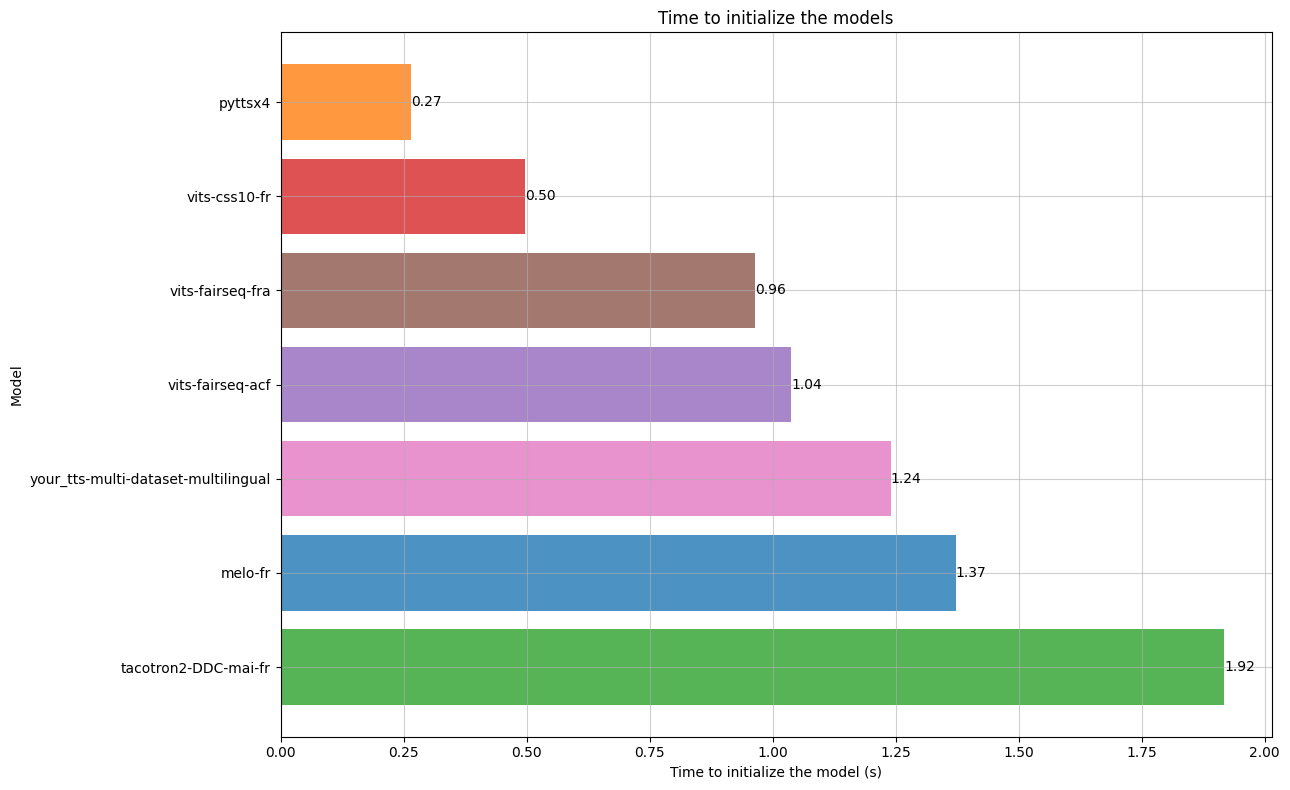

In [11]:
# plot time init per model (bar plot)
df_plot = df_plot[df_plot['model'] != 'xtts_v2-multi-dataset-multilingual']
df_plot = df_plot.groupby('model').mean().reset_index()
df_plot = df_plot.sort_values(by='time_init', ascending=False)

fig, ax = plt.subplots(figsize=(13, 8))
for model in df_plot['model']:
    color = colors[model]
    ax.barh(model, df_plot[df_plot['model'] == model]['time_init'], color=color, alpha=0.8, label=model)
    # write the value on the bar
    ax.text(df_plot[df_plot['model'] == model]['time_init'].values[0], model, f"{df_plot[df_plot['model'] == model]['time_init'].values[0]:.2f}", ha='left', va='center', color='black')
ax.set_xlabel('Time to initialize the model (s)')
ax.set_ylabel('Model')
ax.set_title('Time to initialize the models')
ax.grid(which='major', alpha=0.6)
plt.tight_layout()
plt.show()